<a href="https://colab.research.google.com/github/jiashenyue/house-price-prediction/blob/main/tuning_deep_learning_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House sales prediction

Shenyue Jia | [jiashenyue.info](https://jiashenyue.info)

- In this notebook, we will build and improve a deep learning model to predict the house price, using data from this [Kaggle competition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview).

In [242]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, \
precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, \
classification_report

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer


# Deep learning libraries
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import metrics
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

**Useful Functions**

- The functions are from the [Week 10 Lecture 2 Feature Engineering notebook](https://github.com/coding-dojo-data-science/week-10-lecture-2-feature-engineering/blob/11-7-22/SOLUTION%20Feature%20Engineering%20Code-along.ipynb).

In [243]:
def eval_regression(true, pred, name='Model'):
  scores = pd.DataFrame()
  scores['Model Name'] = [name]
  scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
  scores['MAE'] = [mean_absolute_error(true, pred)]
  scores['R2'] = [r2_score(true, pred)]
  return scores

def plot_history(history):
  """Takes a keras model learning history and plots each metric"""
  
  metrics = history.history.keys()
  
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

## Data

Data is obtained from this [Kaggle competition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview). 
- `train.csv` will be used to train the model
- Trained model will be applied to test data from `test.csv`

In [244]:
# load data
url = 'https://drive.google.com/file/d/1p4eiY1emCtB2pU7sII6DFe7FZkA5JFeG/view?usp=share_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

df = pd.read_csv(url, index_col=[0])
df_backup = df.copy()

display(df.head())
print(df.shape)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


(1460, 80)


In [245]:
# check column info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## Explore and clean the data
1. Drop any duplicates
2. Look for missing values.  If you want to drop rows or columns, now is the time.  Wait on imputing until after the split.
3. Check inconsistencies

### Check duplicates values

In [246]:
# check for duplicates
if df.duplicated().sum()>0:
  # drop duplicates
  print(f'Removed {df.duplicated().sum()} duplicated rows.')
  df.drop_duplicates()
else:
  print('There is no duplicated rows in the dataframe.')

There is no duplicated rows in the dataframe.


### Check missing values

In [247]:
# check for missing values
pd.set_option('display.max_rows',None)
pct_na = df.isna().sum()/len(df)*100
print(df.isna().sum()/len(df)*100)

MSSubClass        0.000000
MSZoning          0.000000
LotFrontage      17.739726
LotArea           0.000000
Street            0.000000
Alley            93.767123
LotShape          0.000000
LandContour       0.000000
Utilities         0.000000
LotConfig         0.000000
LandSlope         0.000000
Neighborhood      0.000000
Condition1        0.000000
Condition2        0.000000
BldgType          0.000000
HouseStyle        0.000000
OverallQual       0.000000
OverallCond       0.000000
YearBuilt         0.000000
YearRemodAdd      0.000000
RoofStyle         0.000000
RoofMatl          0.000000
Exterior1st       0.000000
Exterior2nd       0.000000
MasVnrType        0.547945
MasVnrArea        0.547945
ExterQual         0.000000
ExterCond         0.000000
Foundation        0.000000
BsmtQual          2.534247
BsmtCond          2.534247
BsmtExposure      2.602740
BsmtFinType1      2.534247
BsmtFinSF1        0.000000
BsmtFinType2      2.602740
BsmtFinSF2        0.000000
BsmtUnfSF         0.000000
T

#### Remove columns with too many missing values

In [248]:
# select columns with missing value > 45%
pct_na = pct_na.to_frame().reset_index()
pct_na.columns = ['col','pct_na']
pct_na.head()

,col,pct_na
0,MSSubClass,0.000000
1,MSZoning,0.000000
2,LotFrontage,17.739726
3,LotArea,0.000000
4,Street,0.000000


In [249]:
# obtain column names to be removed
cols_rm = pct_na.loc[(pct_na["pct_na"] >45), ['col']]
cols_rm = cols_rm['col'].values.tolist()
cols_rm

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [250]:
# drop these columns
df = df.drop(columns = cols_rm)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

#### Remove rows with missing values

In [251]:
# obtain column names to be removed
cols_miss = pct_na.loc[(pct_na["pct_na"] < 20) & (pct_na['pct_na']>0), ['col']]
cols_miss = cols_miss['col'].values.tolist()
cols_miss

['LotFrontage',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [252]:
# drop rows with NA in the above columns
df = df.dropna(subset=cols_miss)
print(df.isna().sum()/len(df)*100)

MSSubClass       0.0
MSZoning         0.0
LotFrontage      0.0
LotArea          0.0
Street           0.0
LotShape         0.0
LandContour      0.0
Utilities        0.0
LotConfig        0.0
LandSlope        0.0
Neighborhood     0.0
Condition1       0.0
Condition2       0.0
BldgType         0.0
HouseStyle       0.0
OverallQual      0.0
OverallCond      0.0
YearBuilt        0.0
YearRemodAdd     0.0
RoofStyle        0.0
RoofMatl         0.0
Exterior1st      0.0
Exterior2nd      0.0
MasVnrType       0.0
MasVnrArea       0.0
ExterQual        0.0
ExterCond        0.0
Foundation       0.0
BsmtQual         0.0
BsmtCond         0.0
BsmtExposure     0.0
BsmtFinType1     0.0
BsmtFinSF1       0.0
BsmtFinType2     0.0
BsmtFinSF2       0.0
BsmtUnfSF        0.0
TotalBsmtSF      0.0
Heating          0.0
HeatingQC        0.0
CentralAir       0.0
Electrical       0.0
1stFlrSF         0.0
2ndFlrSF         0.0
LowQualFinSF     0.0
GrLivArea        0.0
BsmtFullBath     0.0
BsmtHalfBath     0.0
FullBath     

In [253]:
df.shape[1]

75

### Check inconsistencies

- We did not find inconsistencies in data

In [254]:
# print unique values
cat_cols = df.select_dtypes(include='object')
for col in cat_cols:
    print(f'- {col}:')
    print(df[col].value_counts(dropna=False))
    print("\n\n")

- MSZoning:
RL         850
RM         173
FV          54
RH           9
C (all)      8
Name: MSZoning, dtype: int64



- Street:
Pave    1090
Grvl       4
Name: Street, dtype: int64



- LotShape:
Reg    760
IR1    301
IR2     26
IR3      7
Name: LotShape, dtype: int64



- LandContour:
Lvl    991
Bnk     45
HLS     44
Low     14
Name: LandContour, dtype: int64



- Utilities:
AllPub    1094
Name: Utilities, dtype: int64



- LotConfig:
Inside     830
Corner     187
CulDSac     44
FR2         29
FR3          4
Name: LotConfig, dtype: int64



- LandSlope:
Gtl    1045
Mod      44
Sev       5
Name: LandSlope, dtype: int64



- Neighborhood:
NAmes      173
CollgCr    122
OldTown     96
Somerst     75
NridgHt     74
Edwards     65
Gilbert     49
NWAmes      45
Sawyer      44
SawyerW     44
BrkSide     42
Crawfor     41
NoRidge     33
Mitchel     30
Timber      29
IDOTRR      27
StoneBr     20
SWISU       19
BrDale      15
Blmngtn     14
ClearCr     11
MeadowV     10
Veenker      7
NPkVill 

- These columns may need to be further engineered to avoid introducing errors to our model

### Check basic stats

- We also need to check if there is any unrealistic values for numeric columns

In [255]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,...,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000
mean,56.128885,70.759598,10132.346435,6.247715,5.575868,1972.412249,1985.915905,109.855576,448.191956,45.252285,...,94.341865,46.946984,22.053016,3.266910,16.498172,3.007313,23.550274,6.335466,2007.786106,187033.263254
std,41.976345,24.508859,8212.249621,1.366797,1.066500,31.189752,20.930772,190.667459,468.728095,159.075003,...,122.624615,64.820019,61.570502,29.655973,58.455303,40.713175,167.135237,2.694558,1.334307,83165.332151
min,20.000000,21.000000,1300.000000,2.000000,2.000000,1880.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,35311.000000
25%,20.000000,60.000000,7606.750000,5.000000,5.000000,1953.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,132500.000000
50%,50.000000,70.000000,9444.500000,6.000000,5.000000,1975.000000,1995.000000,0.000000,384.500000,0.000000,...,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,165750.000000
75%,70.000000,80.000000,11387.250000,7.000000,6.000000,2003.000000,2005.000000,171.750000,712.750000,0.000000,...,169.750000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,221000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,648.000000,2500.000000,12.000000,2010.000000,755000.000000


## Create train and test data

In [256]:
df.shape

(1094, 75)

In [257]:
# Define X and y and train test split
X = df.drop(columns = ['SalePrice'])
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Preprocessing

In [258]:
# create preprocessor
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')

median_imputer = SimpleImputer(strategy='median')
#this is showing for learning purpose but we are not using it here. 
missing_imputer = SimpleImputer(strategy='constant', fill_value='missing')

num_pipeline = make_pipeline(median_imputer, scaler)
cat_pipeline = make_pipeline(missing_imputer, ohe)

In [259]:
# Setup the tuples to pair the processors with the make column selectors
cat_select = make_column_selector(dtype_include='object')
num_select = make_column_selector(dtype_include='number')


num_tuple = (num_pipeline, num_select)
cat_tuple = (cat_pipeline, cat_select)

In [260]:
# Instantiate the make column transformer
processor = make_column_transformer(num_tuple,cat_tuple, 
                                          remainder='drop')

In [261]:
# # create preprocessor
# cat_select = make_column_selector(dtype_include='object')
# num_select = make_column_selector(dtype_include='number')

# scaler = StandardScaler()
# ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')

# num_tuple = (scaler, num_select)
# cat_tuple = (ohe, cat_select)

# processor = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')

In [262]:
# apply preprocessor
X_train_proc = processor.fit_transform(X_train)
X_test_proc = processor.transform(X_test)
 
X_train_proc.shape

(820, 254)

## Model 1

In [263]:
# create and compile the model
model1 = keras.Sequential()
model1.add(Dense(10, input_dim=X_train_proc.shape[1],
          activation = 'relu'))
model1.add(Dense(5, activation = 'relu'))
model1.add(Dense(1, activation = 'linear'))

model1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 10)                2550      
                                                                 
 dense_47 (Dense)            (None, 5)                 55        
                                                                 
 dense_48 (Dense)            (None, 1)                 6         
                                                                 
Total params: 2,611
Trainable params: 2,611
Non-trainable params: 0
_________________________________________________________________


In [264]:
# comple model 1
model1.compile(loss='mse', optimizer='adam',
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])

In [265]:
# fit your model
history = model1.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        epochs = 200,
                        verbose=0)

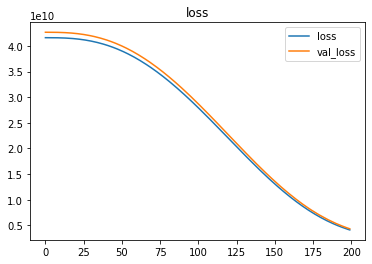

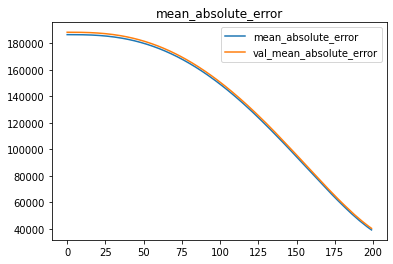

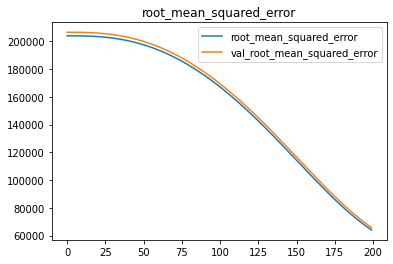

In [266]:
# See how your model is doing
plot_history(history)

In [267]:
# get predictions
train_preds = model1.predict(X_train_proc)
test_preds = model1.predict(X_test_proc)

9/9 [==============================] - 0s 2ms/step


In [268]:
# inspect evaluation metrics
result1_train = eval_regression(y_train, train_preds, name='Model 1 Train')
result1_test = eval_regression(y_test, test_preds, name='Model 2 Test')

frames = [result1_train, result1_test]
result1 = pd.concat(frames)
result1

,Model Name,RMSE,MAE,R2
0,Model 1 Train,63677.024847,38756.416906,0.404833
0,Model 2 Test,65750.002803,40336.737597,0.399491


###Findings##

- This model shows some degree of underfitting as the loss and accuracy metrics for test data is worse than training data in most of the time of training
- When training reaches the end, the testing data showed a better accuracy than training
- We will try to address underfitting by increasing the complexity of this model

## Model 2: add more complexity

- Add another hidden layer to the model

In [269]:
# create and compile the model
model2 = keras.Sequential()
model2.add(Dense(20, input_dim=X_train_proc.shape[1],
          activation = 'relu'))
model2.add(Dense(10, activation = 'relu'))
model2.add(Dense(5, activation = 'relu'))
model2.add(Dense(1, activation = 'linear'))

model2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 20)                5100      
                                                                 
 dense_50 (Dense)            (None, 10)                210       
                                                                 
 dense_51 (Dense)            (None, 5)                 55        
                                                                 
 dense_52 (Dense)            (None, 1)                 6         
                                                                 
Total params: 5,371
Trainable params: 5,371
Non-trainable params: 0
_________________________________________________________________


In [270]:
# comple model 2
model2.compile(loss='mse', optimizer='adam',
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])

In [271]:
# fit your model
history = model2.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        epochs = 200,
                        verbose=0)

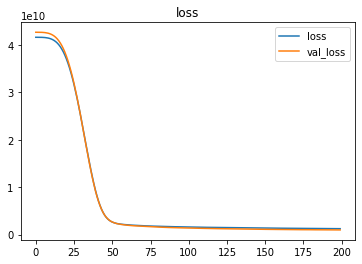

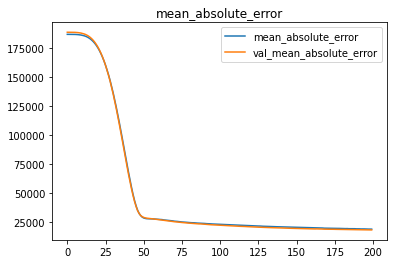

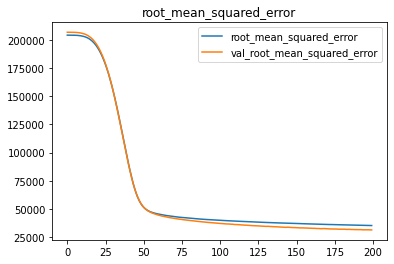

In [272]:
# See how your model is doing
plot_history(history)

In [273]:
# get predictions
train_preds = model2.predict(X_train_proc)
test_preds = model2.predict(X_test_proc)

9/9 [==============================] - 0s 3ms/step


In [274]:
# inspect evaluation metrics
result2_train = eval_regression(y_train, train_preds, name='Model 2 Train')
result2_test = eval_regression(y_test, test_preds, name='Model 2 Test')

frames = [result2_train, result2_test]
result2 = pd.concat(frames)
result2

,Model Name,RMSE,MAE,R2
0,Model 2 Train,35433.799655,19158.199674,0.815707
0,Model 2 Test,31595.453931,18482.093622,0.861332


###**Findings**

- The model performance improved by adding another hidden layer in the model
- Loss and accuracy metrics change in a similar pattern but quickly dropped near `epoch = 50`
- We may consider stopping the training early to avoid over-training

## Model 3: early stopping

In [275]:
# create and compile the model
model3 = keras.Sequential()
model3.add(Dense(20, input_dim=X_train_proc.shape[1],
          activation = 'relu'))
model3.add(Dense(10, activation = 'relu'))
model3.add(Dense(5, activation = 'relu'))
model3.add(Dense(1, activation = 'linear'))

model3.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 20)                5100      
                                                                 
 dense_54 (Dense)            (None, 10)                210       
                                                                 
 dense_55 (Dense)            (None, 5)                 55        
                                                                 
 dense_56 (Dense)            (None, 1)                 6         
                                                                 
Total params: 5,371
Trainable params: 5,371
Non-trainable params: 0
_________________________________________________________________


In [276]:
# comple model 3
model3.compile(loss='mse', optimizer='adam',
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])

In [277]:
# fit your model
early_stopping = EarlyStopping(patience = 5)

history = model3.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        epochs = 200,
                        callbacks = [early_stopping],
                        verbose=0)

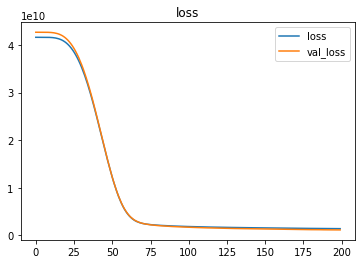

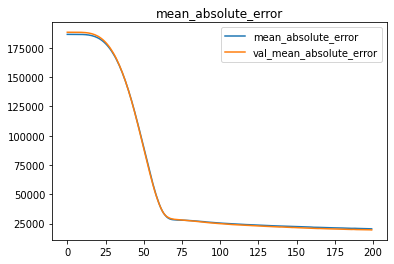

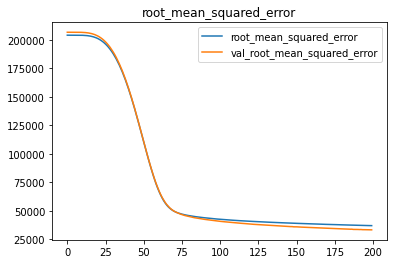

In [278]:
# See how your model is doing
plot_history(history)

In [279]:
# get predictions
train_preds = model3.predict(X_train_proc)
test_preds = model3.predict(X_test_proc)

9/9 [==============================] - 0s 2ms/step


In [280]:
# inspect evaluation metrics
result3_train = eval_regression(y_train, train_preds, name='Model 3 Train')
result3_test = eval_regression(y_test, test_preds, name='Model 3 Test')

frames = [result3_train, result3_test]
result3 = pd.concat(frames)
result3

,Model Name,RMSE,MAE,R2
0,Model 3 Train,37067.410171,20478.233363,0.798322
0,Model 3 Test,33423.816412,19600.239023,0.844818


###**Findings**

- By adding early stopping, we not only reduced the time to train the model, but also improved the model performance

## Best model

- The best model we have tried by far is a model with three hidden layers and early stopping option (**Model 3**)

In [281]:
# show the model details
model3 = keras.Sequential()
model3.add(Dense(20, input_dim=X_train_proc.shape[1],
          activation = 'relu'))
model3.add(Dense(10, activation = 'relu'))
model3.add(Dense(5, activation = 'relu'))
model3.add(Dense(1, activation = 'linear'))

model3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 20)                5100      
                                                                 
 dense_58 (Dense)            (None, 10)                210       
                                                                 
 dense_59 (Dense)            (None, 5)                 55        
                                                                 
 dense_60 (Dense)            (None, 1)                 6         
                                                                 
Total params: 5,371
Trainable params: 5,371
Non-trainable params: 0
_________________________________________________________________


## Test with `test.csv`

In [282]:
# load data
test_url = 'https://drive.google.com/file/d/1pXk57gDMMjGvhDNklk1Q27lyaMb_jLw2/view?usp=share_link'
test_url='https://drive.google.com/uc?id=' + test_url.split('/')[-2]

df_test = pd.read_csv(test_url, index_col=[0])

In [283]:
# remove columns
X = df_test.drop(columns = cols_rm)
X.shape

(1459, 74)

In [284]:
# apply preprocessor
X_proc = processor.transform(X)
X_proc.shape

(1459, 254)

In [285]:
# calculate predictions
y_preds = model3.predict(X_proc)
y_preds

46/46 [==============================] - 0s 1ms/step


array([[0.583699  ],
       [1.1433493 ],
       [0.27380037],
       ...,
       [0.27795428],
       [0.6317415 ],
       [0.20289189]], dtype=float32)

# Reference

- This notebook used some code from the following materials
  - [Week 10 Lecture 2 Feature Engineering](https://github.com/coding-dojo-data-science/week-10-lecture-2-feature-engineering/blob/11-7-22/SOLUTION%20Feature%20Engineering%20Code-along.ipynb)
  - [Week 11 Lecture 2 Code-along Tuning deep learning models](https://github.com/coding-dojo-data-science/week-11-lecture-2-tuning-deep-learning-models/blob/main/SOLUTIONS%20Code-along%20Tuning%20Neural%20Networks.ipynb)
  - [Week 11 Lecture 2 Challenge Tuning deep learning models](https://github.com/coding-dojo-data-science/week-11-lecture-2-tuning-deep-learning-models/blob/main/SOLUTIONS%20Challenge_%20Tuning%20Neural%20Networks.ipynb)